# Lecture 11. Direct solvers for sparse matrices (cont'd). Intro to iterative methods

## Previous lecture: what was already discussed 

- LU decomposition for sparse matrices: make factors sparse!
- Fill-in and the reasons of its appearance
- Arrowhead structure helps to minimize fill-in

Today we will sequentially discuss approaches to minimize fill-in

## Fill-in upper bound minimization: Markowitz pivoting

- General purpose approach to ordering the elements of sparse matrix that will be eliminated
- The Markowitz merit for every non-zero element with indices $(i, j)$ is computed as $(r_i - 1)(c_j - 1)$, where $r_i$ is number of nonzeros elements in the $i$-th row and $c_j$ is a number of non-zero elements in the $j$-th column
- This value is an upper abound on the fill-in after eliminating the $(i, j)$ element. **Why?**
- We can order elements with respect to these values, select the one with minimum value, eliminate it and update matrix. What about stability?
- Then re-compute these values and repeat the procedure
- This method gives us the permutations of rows and columns and sparse factors
- Main drawback is efficient supporting number of nnz in every row and column after matrix update without complete re-calculating
- More details can be found in book [Direct Methods for Sparse Matrices by I. S. Duff, A. M. Erisman, and J. K. Reid](https://oxford.universitypressscholarship.com/view/10.1093/acprof:oso/9780198508380.001.0001/acprof-9780198508380)
- De facto standard approach in solving Linear programming (LP) problems and their MILP modifications

## What if consider only neighbours? We get minimal degree ordering!

- The idea is to eliminate rows and/or columns with fewer non-zeros, update fill-in and then repeat. How it relates to Markowitz pivoting?

- Efficient implementation is an issue (adding/removing elements).

- Current champion is "approximate minimal degree" by Amestoy, Davis, Duff.

- It is **suboptimal** even for 2D PDE problems

- SciPy sparse package [uses](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.splu.html) minimal ordering approach for different matrices ($A^{\top}A$, $A + A^{\top}$) 

## But in these methods we ignore the knowledge of good structure for sparse LU! 
## Let's exploit it explicitly in the method!

## How to formalize reduction to block arrowhead form?

**Definition.** A **separator** in a graph $G$ is a set $S$ of vertices whose removal leaves at
least two connected components.

Separator $S$ gives the following ordering for an $N$-vertex graph $G$:
- Find a separator $S$, whose removal leaves connected components
$T_1$, $T_2$, $\ldots$, $T_k$
- Number the vertices of $S$ from $N − |S| + 1$ to $N$
- Recursively, number the vertices of each component: $T_1$ from $1$ to
$|T_1|$, $T_2$ from $|T_1| + 1$ to $|T_1| + |T_2|$, etc
- If a component is small enough, enumeration in this component is arbitrarily

### Separator and block arrowhead structure: example

Separator for the 2D Laplacian matrix 

$$
 A_{2D} = I \otimes A_{1D} + A_{1D} \otimes I, \quad A_{1D} = \mathrm{tridiag}(-1, 2, -1),
$$

is as follows

<img src='separator.png' width=300> </img>

Once we have enumerated first indices in $\alpha$, then in $\beta$ and separators indices in $\sigma$ we get the following matrix

$$
PAP^\top = \begin{bmatrix} A_{\alpha\alpha} &  & A_{\alpha\sigma} \\  & A_{\beta\beta} & A_{\beta\sigma} \\ A_{\sigma\alpha} & A_{\sigma\beta} & A_{\sigma\sigma}\end{bmatrix}
$$

which has arrowhrad structure.

- Thus, the problem of finding **permutation** was reduced to the problem of finding **graph separator**!

## The method of recursive reduction to block arrowhead structure – Nested dissection

- For blocks $A_{\alpha\alpha}$, $A_{\beta\beta}$ we continue splitting recursively.

- When the recursion is done, we need to eliminate blocks $A_{\sigma\alpha}$ and $A_{\sigma\beta}$. 

- This makes block in the position of $A_{\sigma\sigma}\in\mathbb{R}^{n\times n}$ dense.

Calculation of Cholesky of this block costs $\mathcal{O}(n^3) = \mathcal{O}(N^{3/2})$, where $N = n^2$ is the total number of nodes.

So, the complexity is $\mathcal{O}(N^{3/2})$

## Packages for nested dissection

- MUltifrontal Massively Parallel sparse direct Solver ([MUMPS](http://mumps.enseeiht.fr/))
- [Pardiso](https://www.pardiso-project.org/)
- [Umfpack as part of SuiteSparse](http://faculty.cse.tamu.edu/davis/suitesparse.html)

All of them have interfaces for C/C++, Fortran and Matlab 

### Nested dissection summary

- Enumeration: find a separator.
- Divide-and-conquer paradigm
- Recursively process two subsets of vertices after separation
- In theory, nested dissection gives optimal complexity. 
- In practice, it beats others only for very large problems.

## Separators in practice

- Computing separators is not a **trivial task**.

- Graph partitioning heuristics has been an active research area for many years, often motivated by partitioning for parallel computation.

Existing approaches:

- Spectral partitioning (uses eigenvectors of Laplacian matrix of graph) - more details below
- Geometric partitioning (for meshes with specified vertex coordinates) [review and analysis](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.31.4886&rep=rep1&type=pdf)
- Iterative-swapping ([(Kernighan-Lin, 1970)](http://xilinx.asia/_hdl/4/eda.ee.ucla.edu/EE201A-04Spring/kl.pdf), [(Fiduccia-Matheysses, 1982](https://dl.acm.org/citation.cfm?id=809204))
- Breadth-first search [(Lipton, Tarjan 1979)](http://www.cs.princeton.edu/courses/archive/fall06/cos528/handouts/sepplanar.pdf)
- Multilevel recursive bisection (heuristic, currently most practical) ([review](https://people.csail.mit.edu/jshun/6886-s18/lectures/lecture13-1.pdf) and [paper](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.499.4130&rep=rep1&type=pdf)). Package for such kind of partitioning is called METIS, written in C, and available [here](http://glaros.dtc.umn.edu/gkhome/views/metis)

## One of the ways to construct separators – spectral graph partitioning

- The idea of spectral partitioning goes back to Miroslav Fiedler, who studied connectivity of graphs ([paper](https://dml.cz/bitstream/handle/10338.dmlcz/101168/CzechMathJ_23-1973-2_11.pdf)).

- We need to split the vertices into two sets.

- Consider +1/-1 labeling of vertices and **the cost**

$$E_c(x) = \sum_{j} \sum_{i \in N(j)} (x_i - x_j)^2, \quad N(j) \text{ denotes set of neighbours of a node } j. $$

- We need a balanced partition, thus 

$$\sum_i x_i =  0 \quad \Longleftrightarrow \quad x^\top e = 0, \quad e = \begin{bmatrix}1 & \dots & 1\end{bmatrix}^\top,$$

and since we have +1/-1 labels, we have

$$\sum_i x^2_i = n \quad \Longleftrightarrow \quad \|x\|_2^2 = n.$$

## Graph Laplacian

Cost $E_c$ can be written as (check why)

$$E_c = (Lx, x)$$

where $L$ is the **graph Laplacian**, which is defined as a symmetric matrix with

$$L_{ii} = \mbox{degree of node $i$},$$

$$L_{ij} = -1, \quad \mbox{if $i \ne j$  and there is an edge},$$

and $0$ otherwise.

- Rows of $L$ sum to zero, thus there is an eigenvalue $0$ and gives trivial eigenvector of all ones.
- Eigenvalues are non-negative (why?).

## Partitioning as an optimization problem

- Minimization of $E_c$ with the mentioned constraints leads to a partitioning that tries to minimize number of edges in a separator, while keeping the partition balanced. 

- We now relax the integer quadratic programming to the continuous quadratic programming

$$E_c(x) = (Lx, x)\to \min_{\substack{x^\top e =0, \\ \|x\|_2^2 = n}}$$

## From Fiedler vector to separator

- The solution to the minimization problem is given by the eigenvector (called Fiedler vector) corresponding  to the second smallest eigenvalue of the graph Laplacian. Indeed,

$$
    \min_{\substack{x^\top e =0, \\ \|x\|_2^2 = n}} (Lx, x) = n \cdot \min_{{x^\top e =0}} \frac{(Lx, x)}{(x, x)} = n \cdot \min_{{x^\top e =0}} R(x), \quad R(x) \text{ is the Rayleigh quotient}
$$

- Since $e$ is the eigenvector, corresponding to the smallest eigenvalue, on the space $x^\top e =0$ we get the second minimal eigevalue.

- The sign $x_i$ indicates the partitioning.

- In computations, we need to find out, how to find this second minimal eigenvalue –– we at least know about power method, but it finds the largest. We will discuss iterative methods for eigenvalue problems later in our course.

- This is the main goal of the iterative methods for large-scale linear problems, and can be achieved via few matrix-by-vector products.

Number of vertices = 34
Number of edges = 78


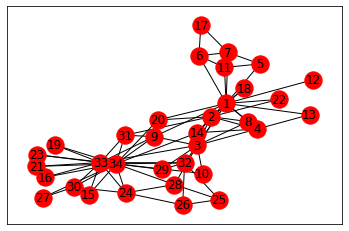

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
kn = nx.read_gml('karate.gml')
print("Number of vertices = {}".format(kn.number_of_nodes()))
print("Number of edges = {}".format(kn.number_of_edges()))
nx.draw_networkx(kn, node_color="red") #Draw the graph

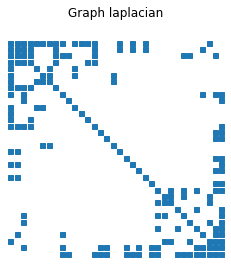

The 2 smallest eigenvalues = [-4.14058418e-15  4.68525227e-01]


In [2]:
import scipy.sparse.linalg as spsplin
Laplacian = nx.laplacian_matrix(kn).asfptype()
plt.spy(Laplacian, markersize=5)
plt.title("Graph laplacian")
plt.axis("off")
plt.show()
eigval, eigvec = spsplin.eigsh(Laplacian, k=2, which="SM")
print("The 2 smallest eigenvalues =", eigval)

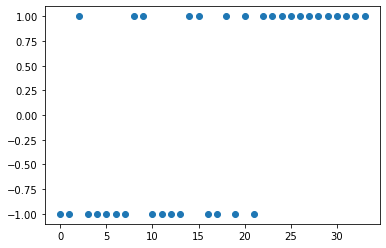

Sum of elements in Fiedler vector = 8.743006318923108e-16


In [3]:
plt.scatter(np.arange(len(eigvec[:, 1])), np.sign(eigvec[:, 1]))
plt.show()
print("Sum of elements in Fiedler vector = {}".format(np.sum(eigvec[:, 1].real)))

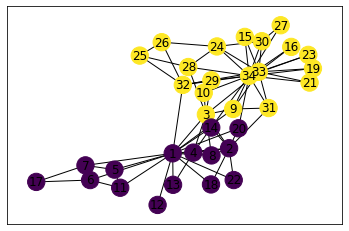

In [4]:
nx.draw_networkx(kn, node_color=np.sign(eigvec[:, 1]))

### Summary on demo

- Here we call SciPy sparse function to find fixed number of eigenvalues (and eigenvectors) that are smallest (other options are possible)
- Details of the underlying method we will discuss soon
- Fiedler vector gives simple separation of the graph
- To separate graph on more than two parts you should use eigenvectors of laplacian as feature vectors and run some clustering algorithm, e.g. $k$-means

### Fiedler vector and algebraic connectivity of a graph

**Definition.** The algebraic connectivity of a graph is the second-smallest eigenvalue of the Laplacian matrix.

**Claim.** The algebraic connectivity of a graph is greater than 0 if and only if a graph is a connected graph.

## Practical problems

Computing bisection recursively is expensive. 

As an alternative, one typically computes **multilevel bisection** that consists of 3 phases.

- Graph coarsening: From a given graph, we join vertices into larger nodes, and get sequences of graphs $G_1, \ldots, G_m$. 
- At the coarse level, we do high-quality bisection
- Then, we do **uncoarsening**: we propagate the splitting from $G_k$ to $G_{k-1}$ and improve the quality of the split by local optimization algorithms (refinement). 

## Practical problems (2)

- Once the permutation has been computed, we need to implement the elimination, making use of efficient computational kernels. 

- If in the elemination we will be able to get the elements into **blocks**, we will be able to use BLAS-3 computations. 

- It is done by **supernodal** data structures: 

- If adjacent rows have the same sparsity structure, they can be stored in **blocks**:

- Also, we can use such structure in efficient computations!

[Details in this survey](https://arxiv.org/pdf/1907.05309.pdf)

## Take home message about direct methods for sparse matrices

- Sparse matrices & graphs ordering
- Ordering is important for LU fill-in: more details in the next lecture
- Markowitz pivoting and minimal degree ordering
- Orderings from SciPy sparse package
- Separators and how do they help in fill-in minimization
- Nested dissection idea
- Fiedler vector and spectral bipartitioning

# The main topics for today

Concept of **iterative methods** for linear systems: 
- Richardson iteration and its convergence
- Chebyshev iteration

# Iterative methods

- If we want to achieve $\mathcal{O}(N)$ complexity of solving sparse linear systems, then direct solvers are not appropriate.

- If we want to solve partial eigenproblem, the full eigendecomposition is too costly.

- For both problems we will use iterative, Krylov subspace solvers, which treat the matrix as a **black-box** linear operator.

## Matrix as a black box

- We have now an absolutely different view on a matrix: matrix is now a **linear operator**, that acts on a vector,  
and this action can be computed in $\mathcal{O}(N)$ operations.

- **This is the only information** we know about the matrix: the <span style='color:red'> matrix-by-vector product (matvec) </span>

- Can we solve linear systems using only matvecs?

- Of course, we can multiply by the colums of the identity matrix, and recover the full matrix, but it is not what we need.

## Richardson iteration
The simplest idea is the **"simple iteration method"** or **Richardson iteration**.  


  $$Ax = f,$$
  $$\tau  (Ax - f) = 0,$$
   $$x - \tau (Ax - f) = x,$$
   $$x_{k+1} = x_k - \tau (Ax_k - f),$$
   
   where $\tau$ is the **iteration parameter**, which can be always chosen such that the method **converges**.

## Connection to ODEs

- The Richardson iteration has a deep connection to the Ordinary Differential Equations (ODE).


- Consider a time-dependent problem ($A=A^*>0$)

$$\frac{dy}{dt} + A y = f, \quad y(0) = y_0.$$

- Then $y(t) \rightarrow A^{-1} f$ as $t \rightarrow \infty$, and the **Euler scheme** reads

$$\frac{y_{k+1} - y_k}{\tau} = -A y_k + f.$$

which leads to the Richardson iteration

$$
    y_{k+1} = y_k - \tau(Ay_k -f)
$$

## Convergence of the Richardson method

- Let $x_*$ be the solution; introduce an error $e_k = x_{k} - x_*$, then  

$$
     e_{k+1} = (I - \tau A) e_k,
$$

therefore if $\Vert I - \tau A \Vert < 1$ in any norm, the iteration converges. 

- For symmetric positive definite case it is always possible to select $\tau$ such that the method converges.

- What about the non-symmetric case? Below demo will be presented...

## Optimal parameter choice

- The choise of $\tau$ that minimizes $\|I - \tau A\|_2$ for $A = A^* > 0$ is (prove it!)

$$
  \tau_\mathrm{opt} = \frac{2}{\lambda_{\min} + \lambda_{\max}}.
$$

where $\lambda_{\min}$ is the minimal eigenvalue, and $\lambda_{\max}$ is the maximal eigenvalue of the matrix $A$.

- So, to find optimal parameter, we need to know the **bounds of the spectrum** of the matrix $A$, and we can compute it by using **power method**.

## Condition number and convergence speed

Even with the optimal parameter choice, the error at the next step satisfies

$$\|e_{k+1}\|_2 \leq q \|e_k\|_2 , \quad\rightarrow \quad \|e_k\|_2 \leq q^{k} \|e_0\|_2,$$

where 

$$
   q = \frac{\lambda_{\max} - \lambda_{\min}}{\lambda_{\max} + \lambda_{\min}} = \frac{\mathrm{cond}(A) - 1}{\mathrm{cond}(A)+1},
$$

$$\mathrm{cond}(A) = \frac{\lambda_{\max}}{\lambda_{\min}} \quad \text{for} \quad A=A^*>0$$

is the condition number of $A$.

Let us do some demo...

Maximum eigenvalue = 3.6825070656623624, minimum eigenvalue = 0.08101405277100562
Condition number = 45.45516413147901
[0.9186479  0.94484203 0.95170654 0.95466793 0.95595562 0.95651542
 0.9567591  0.95686534 0.95691172 0.95693198 0.95694084 0.95694472
 0.95694642 0.95694716 0.95694748 0.95694763 0.95694769 0.95694771
 0.95694773 0.95694773 0.95694773 0.95694774 0.95694774 0.95694774
 0.95694774 0.95694774 0.95694774 0.95694774 0.95694774 0.95694774
 0.95694774 0.95694774 0.95694774 0.95694774 0.95694774 0.95694774
 0.95694774 0.95694774 0.95694774 0.95694774 0.95694774 0.95694774
 0.95694774 0.95694774 0.95694774 0.95694774 0.95694774 0.95694774
 0.95694774 0.95694774 0.95694774 0.95694774 0.95694774 0.95694774
 0.95694774 0.95694774 0.95694774 0.95694774 0.95694774 0.95694774
 0.95694774 0.95694774 0.95694774 0.95694774 0.95694774 0.95694774
 0.95694774 0.95694774 0.95694774 0.95694774 0.95694774 0.95694774
 0.95694774 0.95694774 0.95694774 0.95694774 0.95694774 0.95694774
 0.9569477

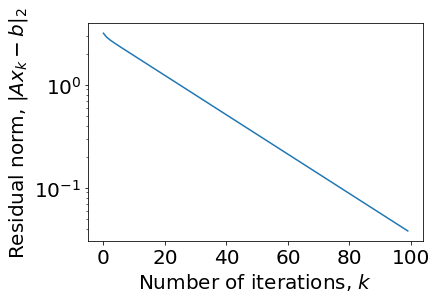

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import scipy as sp
import scipy.sparse
import scipy.sparse.linalg as spla
import scipy
from scipy.sparse import csc_matrix
n = 10
ex = np.ones(n);
A = sp.sparse.spdiags(np.vstack((-ex,  2*ex, -ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.ones(n)
ev1, vec = spla.eigsh(A, k=2, which='LA')
ev2, vec = spla.eigsh(A, k=2, which='SA')
lam_max = ev1[0]
lam_min = ev2[0]

tau_opt = 2.0/(lam_max + lam_min)

fig, ax = plt.subplots()
plt.close(fig)

niters = 100
x = np.zeros(n)
res_richardson = []
for i in range(niters):
    rr = A.dot(x) - rhs
    x = x - tau_opt * rr
    res_richardson.append(np.linalg.norm(rr))
#Convergence of an ordinary Richardson (with optimal parameter)
plt.semilogy(res_richardson)
plt.xlabel("Number of iterations, $k$", fontsize=20)
plt.ylabel("Residual norm, $\|Ax_k - b\|_2$", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
print("Maximum eigenvalue = {}, minimum eigenvalue = {}".format(lam_max, lam_min))
cond_number = lam_max.real / lam_min.real
print("Condition number = {}".format(cond_number))
print(np.array(res_richardson)[1:] / np.array(res_richardson)[:-1])
print("Theoretical factor: {}".format((cond_number - 1) / (cond_number + 1)))

- Thus, for **ill-conditioned** matrices the error of the simple iteration method decays very slowly.<br>
- This is another reason why **condition number** is so important:

    * Besides  the bound on the error in the solution, it also gives an estimate of the number of iterations for the iterative methods.

- Main questions for the iterative method is how to make the matrix **better conditioned**.
- The answer is <span style='color:red'> use preconditioners</span>. Preconditioners will be discussed in further lectures.

### Consider non-hermitian matrix $A$

Possible cases of Richardson iteration behaviour:
- convergence
- divergence
- almost stable trajectory

**Q:** how can we identify our case **before** running iterative method?

In [6]:
# B = np.random.randn(2, 2)
B = np.array([[1, 2], [-1, 0]])
# B = np.array([[0, 1], [-1, 0]])
x_true = np.zeros(2)
f = B.dot(x_true)
eigvals = np.linalg.eigvals(B)
print("Spectrum of the matrix = {}".format(eigvals))

# Run Richardson iteration
x = np.array([0, -1])
tau = 1e-2
conv_x = [x]
r = B.dot(x) - f
conv_r = [np.linalg.norm(r)]
num_iter = 1000
for i in range(num_iter):
    x = x - tau * r
    conv_x.append(x)
    r = B.dot(x) - f
    conv_r.append(np.linalg.norm(r))

Spectrum of the matrix = [0.5+1.32287566j 0.5-1.32287566j]


Text(0, 0.5, 'Residual norm')

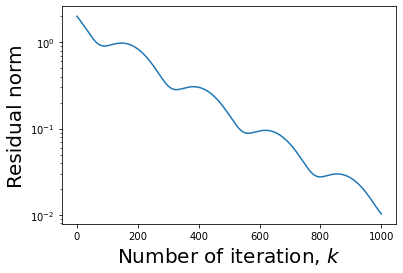

In [7]:
plt.semilogy(conv_r)
plt.xlabel("Number of iteration, $k$", fontsize=20)
plt.ylabel("Residual norm", fontsize=20)

Text(0.5, 1.0, '$x_0 = (0, -1)$')

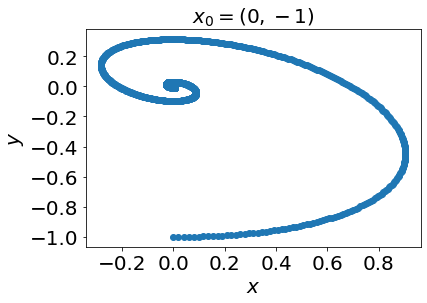

In [8]:
plt.scatter([x[0] for x in conv_x], [x[1] for x in conv_x])
plt.xlabel("$x$", fontsize=20)
plt.ylabel("$y$", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("$x_0 = (0, -1)$", fontsize=20)

## Better iterative methods

But before preconditioners, we can use **better iterative methods**. 

There is a whole **zoo** of iterative methods, but we need to know just few of them.

## Attempt 1: The steepest descent method

- Suppose we **change** $\tau$ every step, i.e. 

$$
   x_{k+1} = x_k - \tau_k (A x_k - f).
$$

- A possible choice of $\tau_k$ is such that it minimizes norm of the current residual

$$ \tau_k = \arg\min_{\tau} \|A(x_k - \tau_k (A x_k - f)) - f\|_2^2.$$

- This problem can be solved analytically (derive this solution!)

$$ \tau_k = \frac{r_k^{\top}r_k}{r_k^{\top}Ar_k}, \quad r_k = Ax_k - f $$

- This method is called **the steepest descent**.

- However, it still converges similarly to the Richardson iteration.

## Attempt 2: Chebyshev iteration

Another way to find $\tau_k$ is to consider

$$e_{k+1} = (I - \tau_k A) e_k = (I - \tau_k A) (I - \tau_{k-1} A)  e_{k-1} = \ldots = p(A) e_0, $$

where $p(A)$ is a **matrix polynomial** (simplest matrix function)  

$$
   p(A) = (I - \tau_k A) \ldots (I - \tau_0 A),
$$

and $p(0) = 1$.

## Optimal choice of time steps
The error is written as 

$$e_{k+1} = p(A) e_0, $$

and hence

$$\|e_{k+1}\| \leq \|p(A)\| \|e_0\|, $$

where $p(0) = 1$ and $p(A)$ is a **matrix polynomial**. 

To get better **error reduction**, we need to minimize

$$\Vert p(A) \Vert$$ 

over all possible polynomials $p(x)$ of degree $k+1$ such that $p(0)=1$. We will use $\|\cdot\|_2$.

##  Polynomials least deviating from zeros

Important special case: $A = A^* > 0$.

Then $A = U \Lambda U^*$, 

and 



$$\Vert p(A) \Vert_2 = \Vert U p(\Lambda) U^* \Vert_2 = \Vert p(\Lambda) \Vert_2 = \max_i |p(\lambda_i)| \overset{!}{\leq}
\max_{\lambda_\min \leq \lambda {\leq} \lambda_\max} |p(\lambda)|.$$

The latter inequality is the only approximation. Here we make a <span style='color:red'> crucial assumption </span> that we do not want to benefit from distribution of spectra between $\lambda_\min$ and $\lambda_\max$.

Thus, we need to find a polynomial such that $p(0) = 1$, that has the least possible deviation from $0$ on $[\lambda_\min, \lambda_\max]$.

##  Polynomials least deviating from zeros (2)

We can do the affine transformation of the interval $[\lambda_\min, \lambda_\max]$ to the interval $[-1, 1]$:

$$
\xi = \frac{{\lambda_\max + \lambda_\min - (\lambda_\min-\lambda_\max)x}}{2}, \quad x\in [-1, 1].
$$

The problem is then reduced to the problem of finding the **polynomial least deviating from zero** on an interval $[-1, 1]$.

## Exact solution: Chebyshev polynomials

The exact solution to this problem is given by the famous **Chebyshev polynomials** of the form

$$T_n(x) =  \cos (n \arccos x)$$

## What do you need to know about Chebyshev polynomials

1. This is a polynomial! 

2. We can express $T_n$ from $T_{n-1}$ and $T_{n-2}$: 

$$T_n(x) = 2x T_{n-1}(x) - T_{n-2}(x), \quad T_0(x)=1, \quad T_1(x)=x$$

3. $|T_n(x)| \leq 1$ on $x \in [-1, 1]$.

4. It has $(n+1)$ **alternation points**, where the maximal absolute value is achieved (this is the sufficient and necessary condition for the **optimality**) (Chebyshev alternance theorem, no proof here).

5. The **roots** are just 

$$n \arccos x_k = \frac{\pi}{2} + \pi k, \quad \rightarrow\quad x_k = \cos \frac{\pi(2k + 1)}{2n}, \; k = 0, \ldots,n-1$$

We can plot them...

Text(0.5, 1.0, 'Interval $x\\in[-1.1, 1.1]$')

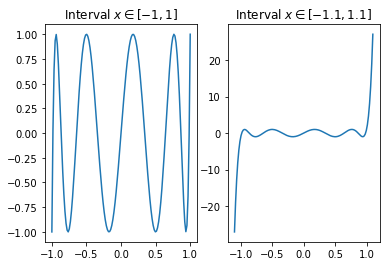

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
x1 = np.linspace(-1, 1, 128)
x2 = np.linspace(-1.1, 1.1, 128)
p = np.polynomial.Chebyshev((0, 0, 0, 0, 0, 0, 0, 0, 0, 1), (-1, 1)) #These are Chebyshev series, a proto of "chebfun system" in MATLAB
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x1, p(x1))
ax1.set_title('Interval $x\in[-1, 1]$')
ax2.plot(x2, p(x2))
ax2.set_title('Interval $x\in[-1.1, 1.1]$')

## Convergence of the Chebyshev-accelerated Richardson iteration

Note that $p(x) = (1-\tau_n x)\dots (1-\tau_0 x)$, hence roots of $p(x)$ are $1/\tau_i$ and that we additionally need to map back from $[-1,1]$ to $[\lambda_\min, \lambda_\max]$.
This results into 

$$\tau_i = \frac{2}{\lambda_\max + \lambda_\min - (\lambda_\max - \lambda_\min)x_i}, \quad x_i = \cos \frac{\pi(2i + 1)}{2n}\quad i=0,\dots,n-1$$

The convergence (we only give the result without the proof) is now given by

$$
   e_{k+1} \leq C q^k e_0, \quad q = \frac{\sqrt{\mathrm{cond}(A)}-1}{\sqrt{\mathrm{cond}(A)}+1},
$$

which is better than in the Richardson iteration.

In [10]:
import scipy as sp
from scipy import sparse

[3.6823714727622603, 3.6812868520771196, 3.679118264041781, 3.67586701493259, 3.671535063180437, 3.666125018191075, 3.659640138773312, 3.652084331176023, 3.6434621467351755, 3.633778779132272, 3.6230400612658724, 3.611252461738073, 3.598423080958062, 3.5845596468650998, 3.569670510273498, 3.5537646398423974, 3.5368516166733874, 3.5189416285392063, 3.5000454637470084, 3.4801745046398915, 3.4593407207405993, 3.4375566615415263, 3.414835448945377, 3.3911907693610166, 3.3666368654592964, 3.341188527593797, 3.314861084891674, 3.2876703960199647, 3.2596328396329195, 3.2307653045061153, 3.2010851793632846, 3.170610342402003, 3.139359150524528, 3.1073504282802893, 3.0746034565266838, 3.041137960815007, 3.0069740995085215, 2.972132451639808, 2.93663400451473, 2.9005001410704634, 2.8637526269952147, 2.826413597617384, 2.7885055445720734, 2.750051302252964, 2.711074034057731, 2.6715972184352825, 2.6316446347432154, 2.5912403489240226, 2.5504086990086683, 2.5091742804562673, 2.467561931338702, 2.4

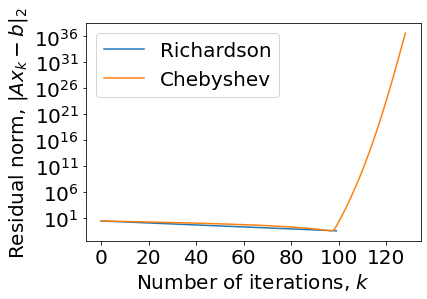

In [12]:
import numpy as np
import matplotlib.pyplot as plt

A = sp.sparse.spdiags(np.vstack((-ex,  2*ex, -ex)), [-1, 0, 1], n, n, 'csr'); 
rhs = np.ones(n)
ev1, vec = spla.eigsh(A, k=2, which='LA')
ev2, vec = spla.eigsh(A, k=2, which='SA')
lam_max = ev1[0]
lam_min = ev2[0]

niters = 128
roots = [np.cos((np.pi * (2 * i + 1)) / (2 * niters)) for i in range(niters)]
taus = [(lam_max + lam_min - (lam_min - lam_max) * r) / 2 for r in roots]
x = np.zeros(n)
r = A.dot(x) - rhs
res_cheb = [np.linalg.norm(r)]

print(taus)

for i in range(niters):
    x = x - 1.0 / taus[i] * r
    r = A.dot(x) - rhs
    res_cheb.append(np.linalg.norm(r))
    
plt.semilogy(res_richardson, label="Richardson")
plt.semilogy(res_cheb, label="Chebyshev")
plt.legend(fontsize=20)
plt.xlabel("Number of iterations, $k$", fontsize=20)
plt.ylabel("Residual norm, $\|Ax_k - b\|_2$", fontsize=20)
plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)

### What happened with great Chebyshev iterations?

[3.6823714727622603, 3.6812868520771196, 3.679118264041781, 3.67586701493259, 3.671535063180437, 3.666125018191075, 3.659640138773312, 3.652084331176023, 3.6434621467351755, 3.633778779132272, 3.6230400612658724, 3.611252461738073, 3.598423080958062, 3.5845596468650998, 3.569670510273498, 3.5537646398423974, 3.5368516166733874, 3.5189416285392063, 3.5000454637470084, 3.4801745046398915, 3.4593407207405993, 3.4375566615415263, 3.414835448945377, 3.3911907693610166, 3.3666368654592964, 3.341188527593797, 3.314861084891674, 3.2876703960199647, 3.2596328396329195, 3.2307653045061153, 3.2010851793632846, 3.170610342402003, 3.139359150524528, 3.1073504282802893, 3.0746034565266838, 3.041137960815007, 3.0069740995085215, 2.972132451639808, 2.93663400451473, 2.9005001410704634, 2.8637526269952147, 2.826413597617384, 2.7885055445720734, 2.750051302252964, 2.711074034057731, 2.6715972184352825, 2.6316446347432154, 2.5912403489240226, 2.5504086990086683, 2.5091742804562673, 2.467561931338702, 2.4

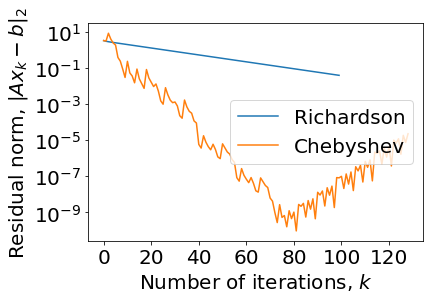

In [14]:
niters = 128
roots = [np.cos((np.pi * (2 * i + 1)) / (2 * niters)) for i in range(niters)]
taus = [(lam_max + lam_min - (lam_min - lam_max) * r) / 2 for r in roots]
x = np.zeros(n)
r = A.dot(x) - rhs
res_cheb_even = [np.linalg.norm(r)]
print(taus)

# Implementation may be non-optimal if number of iterations is not power of two
def leb_shuffle_2n(n):
    if n == 1:
        return np.array([0,], dtype=int)
    else:
        prev = leb_shuffle_2n(n // 2)
        ans = np.zeros(n, dtype=int)
        ans[::2] = prev
        ans[1::2] = n - 1 - prev
        return ans

good_perm_even = leb_shuffle_2n(niters)
print(good_perm_even, len(good_perm_even))
# good_perm_even = np.random.permutation([i for i in range(niters)])

for i in range(niters):
    x = x - 1.0/taus[good_perm_even[i]] * r
    r = A.dot(x) - rhs
    res_cheb_even.append(np.linalg.norm(r))

    
plt.semilogy(res_richardson, label="Richardson")
plt.semilogy(res_cheb_even, label="Chebyshev")
plt.legend(fontsize=20)
plt.xlabel("Number of iterations, $k$", fontsize=20)
plt.ylabel("Residual norm, $\|Ax_k - b\|_2$", fontsize=20)
plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)

- Permutation of roots of Chebyshev polynomial has crucial effect on convergence
- On the optimal permutation you can read in paper (V. Lebedev, S. Finogenov 1971)  ([ru](http://www.mathnet.ru/links/42ab1a270ad179d43359ef8fab53422c/zvmmf6870.pdf), [en](https://www.sciencedirect.com/science/article/abs/pii/0041555371901698?via%3Dihub))

### [Chebfun](http://www.chebfun.org/) project

- Opensource project for numerical computing ([Python](https://github.com/chebpy/chebpy) and [Matlab](https://github.com/chebfun/chebfun) interfaces)
- It is based on numerical algorithms working with piecewise polynomial interpolants and Chebyshev polynomials
- This project was initiated by Nick Trefethen and his student Zachary Battles in 2002, see [paper on chebfun project in SISC](http://www.chebfun.org/publications/chebfun_paper.pdf)
- Chebfun toolbox focuses mostly on the following problems
    - Approximation
    - Quadrature
    - ODE
    - PDE
    - Rootfinding
    - 1D global optimization

## Beyond Chebyshev

- We have made an important assumption about the spectrum: it is contained within an interval over the real line (and we need to know the bounds)

- If the spectrum is contained within **two intervals**, and we know the bounds, we can also put the optimization problem for the **optimal polynomial**.

## Spectrum of the matrix contained in multiple segments

- For the case of **two segments** the best polynomial is given by **[Zolotarev polynomials](https://www.encyclopediaofmath.org/index.php/Zolotarev_polynomials)** (expressed in terms of elliptic functions). Original paper was published in 1877, see details [here](http://gpntb.dlibrary.org/ru/nodes/4245-zolotarev-e-prilozhenie-ellipticheskih-funktsiy-k-voprosam-o-funktsiyah-naimenee-i-naibolee-otklonyayuschihsya-ot-nulya-spb-1877) 

- For the case of **more than two segments** the best polynomial can be expressed in terms of **hyperelliptic functions**

## How can we make it better

- The implementation of the Chebyshev acceleration requires the knowledge of the spectrum.

- It only stores the **previous vector** $x_k$ and computes the new correction vector

$$r_k = A x_k - f.$$

- It belongs to the class of **two-term** iterative methods, i.e. it approximates $x_{k+1}$ using 2 vectors: $x_k$ and $r_k$.

- It appears that if we **store more vectors**, then we can go without the spectrum estimation (and better convergence in practice)!

## Crucial point: Krylov subspace

The Chebyshev method produces the approximation of the form

$$x_{k+1} = x_0 + p(A) r_0,$$

i.e. it lies in the **Krylov subspace** of the matrix  which is defined as

$$
   \mathcal{K}_k(A, r_0) = \mathrm{Span}(r_0, Ar_0, A^2 r_0, \ldots, A^{k-1}r_0 )
$$

The most natural approach then is to find the vector in this **linear subspace** that minimizes 
certain **norm of the error**

## Idea of Krylov methods

The idea is to minimize given functional:
- Energy norm of error for systems with hermitian positive-definite matrices (CG method).
- Residual norm for systems with general matrices (MINRES and GMRES methods).
- Rayleigh quotient for eigenvalue problems (Lanczos method).

To make methods practical one has to 
1. Orthogonalize vectors $A^i r_0$ of the Krylov subspace for stability (Lanczos process).
2. Derive recurrent formulas to decrease complexity.

We will consider these methods in details on the next lecture.

## Take home message

- Main idea of iterative methods
- Richardson iteration: hermitian and non-hermitian case
- Chebyshev acceleration
- Definition of Krylov subspace

### Questions?

In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()